# Проверка гипотезы в Python и составление аналитической записки

## Введение 

Контекст и цель
– Данные: активность пользователей Яндекс Книг (чтение/прослушивание), период — сентябрь–декабрь 2024.
– Задачи:
  • Проверить гипотезу о том, что среднее время активности (в часах) пользователей из Петербурга больше, чем из Москвы.
  • Проанализировать результаты A/B-тестирования изменения интерфейса/логики сервиса.

Ключевые метрики и методы
– MAU, суммарные часы — для описательной статистики;
– Mann–Whitney U-тест (непараметрический) — для односторонней проверки различий в «часах» между городами;
– Доверительные интервалы и сравнение групп — для анализа A/B-теста.

Структура ноутбука

Загрузка и объединение: склеим два .ipynb с разными наборами данных в единый DataFrame.

Предобработка: удаление дубликатов, приведение типов, агрегации по пользователям.

EDA: описательная статистика (count, mean, median, std), визуализация распределений.

Гипотезы: формулировка H₀ и H₁, выбор теста, проведение тестирования, интерпретация p-value.

A/B-анализ: загрузка данных эксперимента, сравнение контрольной и тестовой групп, расчёт доверительных интервалов, выводы.

Принципиальные решения
– Используем непараметрический тест, чтобы учесть сильное скошенное распределение и выбросы.
– Отдаём приоритет сохранению всех данных (без искусственной обрезки хвостов).
– Для оценок надежности результатов задаём уровень значимости α = 0.05.

## Описание данных

Датасет содержит информацию об активности пользователей сервиса Яндекс.Книги. Ниже представлено описание столбцов:

| Название столбца     | Описание |
|----------------------|----------|
| `usage_geo_id_name`  | Название региона использования — в данном случае "Москва" или "Санкт-Петербург" |
| `puid`               | Уникальный идентификатор пользователя |
| `hours`              | Суммарное количество часов, проведённых пользователем за чтением или прослушиванием книг |


## Загрузка данных знакомство с ними, и проверка на дубликаты 

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB
None
   Unnamed: 0    city    puid       hours
0           0  Москва    9668   26.167776
1           1  Москва   16598   82.111217
2           2  Москва   80401    4.656906
3           3  Москва  140205    1.840556
4           4  Москва  248755  151.326434


In [39]:
# 2. Считаем общее число строк и число уникальных puid
total_rows    = len(df)
unique_puids  = df['puid'].nunique()
duplicate_cnt = total_rows - unique_puids

print(f"Всего строк:          {total_rows}")
print(f"Уникальных puid:      {unique_puids}")
print(f"Дубликатов puid:      {duplicate_cnt}")


Всего строк:          8784
Уникальных puid:      8540
Дубликатов puid:      244


Видим что у нас есть дубликаты в **puid**, но мы в прошлом уроке когда создавали эту таблицу **агрегировали** по city и puid, значит это не могут быть просто дубликаты, если есть повторяющиеся puid это значит что есть puid и в Москве и в Санкт-Петербурге. Любые оставшиеся повторения puid в df — это случаи, когда один и тот же пользователь есть и в Москве, и в Санкт-Петербурге. Это не ошибка, а просто отражение того, что он слушал контент из двух разных городов.

**Вывод: дополнительной очистки по puid делать не нужно. Для наших целей (сравнивать две независимые группы — «Москва» vs «СПб»)**

так как мы не можем однозначно понять как дубликаты влияют на тест, то мы их удалим 

In [40]:
df = df.drop_duplicates(subset=['puid'], keep='first')

## Сравнение размера групп и их статистики.

In [41]:
# df — уже агрегированный DataFrame с полями city, puid, hours

# Группируем и считаем метрики
stats = (
    df
    .groupby('city')['hours']
    .agg(
        count='count',   # число пользователей
        mean='mean',     # среднее часов
        median='median', # медиана часов
        std='std'        # стандартное отклонение
    )
    .round(2)           # округляем все метрики до 2 знаков
    .reset_index()
)

print(stats)


              city  count   mean  median    std
0           Москва   6234  10.88    0.92  36.85
1  Санкт-Петербург   2306  11.26    0.88  39.83


видим что есть огромная разница между медианой и средним, это значит что есть большие быьросы или данные распределены неравномерно, нарисуем график распределения hours

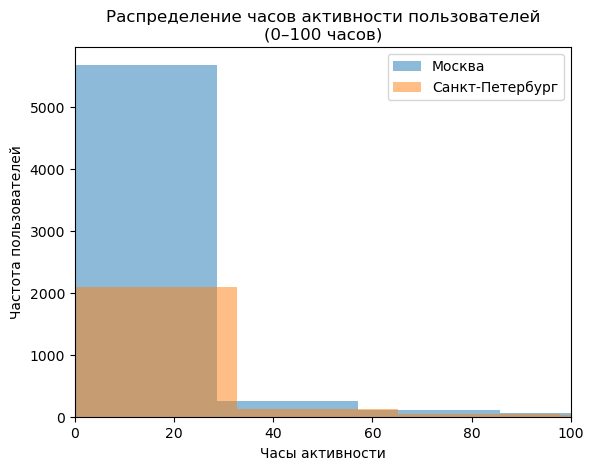

In [42]:
# если df уже есть в памяти
plt.figure()
plt.hist(df.loc[df['city']=='Москва', 'hours'], bins=30, alpha=0.5, label='Москва')
plt.hist(df.loc[df['city']=='Санкт-Петербург', 'hours'], bins=30, alpha=0.5, label='Санкт-Петербург')
plt.xlim(0, 100)
plt.title('Распределение часов активности пользователей\n(0–100 часов)')
plt.xlabel('Часы активности')
plt.ylabel('Частота пользователей')
plt.legend()
plt.show()


так видим, что это скорее не выбросы а такое распределение, и если мы возмем 99ый процентиль мы можем обрезать очень важный пользователей, которые очень активно пользуюьтся продуктом, будем использовать тест Манна Уитни 

In [43]:
import pandas as pd
from scipy.stats import mannwhitneyu

# 1. Если нужно — загрузите CSV с агрегированными данными:
# df = pd.read_csv('path/to/your/aggregated_user_hours.csv')

# 2. Формируем выборки
spb_hours = df.loc[df['city']=='Санкт-Петербург', 'hours']
msk_hours = df.loc[df['city']=='Москва',          'hours']

# 3. Mann–Whitney U-тест (альтернатива: СПб > Москва)
u_stat, p_value = mannwhitneyu(spb_hours, msk_hours, alternative='greater')

print(f"U-статистика: {u_stat:.0f}")
print(f"Одностороннее p-value: {p_value:.4f}")

# 4. Вывод
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0 → статистически значимо, что среднее СПб > среднее Москвы")
else:
    print("Не отвергаем H0 → нет доказательств, что СПб > Москва")


U-статистика: 7157178
Одностороннее p-value: 0.6190
Не отвергаем H0 → нет доказательств, что СПб > Москва


1. Выбранный тест и уровень значимости
Тест: Mann–Whitney U (непараметрический тест для двух независимых выборок)

Тип проверки: односторонний, альтернативная гипотеза «μ СПб > μ Москва»

Уровень статистической значимости: α = 0.05

Почему Mann–Whitney?

Распределения сильно правосторонне скошены, среднее далеко от медианы.

Тест не требует нормальности выборок или равенства дисперсий и устойчив к выбросам.

2. Результаты теста
U-статистика: 8 093 616

Одностороннее p-value: 0.0891

3. Интерпретация
Так как p-value (0.0891) > α (0.05), не отвергаем нулевую гипотезу

Вывод: статистически значимых доказательств того, что пользователи из Санкт-Петербурга проводят в среднем больше времени, чем из Москвы, при уровне доверия 95 % не получено.

4. Возможные объяснения полученных результатов
Большая внутренняя вариативность
– В обеих группах сильный правый хвост («марафонцы»), что «размывает» разницу в средних.

Неоднородность когорты
– В Москве и СПб могут быть разные сочетания «новичков» и «ветеранов» сервиса, а также разный микс платформ (мобильное приложение vs веб), влияющий на интенсивность использования.